In [25]:
import math
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# 2-D distribution of follicles

## Supportive functions for the simulation

### Sketching follicles and ovary

In [10]:
# Function to sketch circular follicle given in dataframe df
def sketch_follicles(df):
    t = np.arange(0,1.01, 0.01) * np.pi * 2.0
    for ind in df.index:
        r = df['fol_size'][ind]
        x = df['x'][ind] + r  * np.cos(t)
        y = df['y'][ind] + r  * np.sin(t)
        plt.plot(x,y)
    
# Sketch circular ovary diameter r    
def sketch_ovary(r):
    t = np.arange(0,1.01, 0.01) * np.pi * 2.0
    x = r  * np.cos(t)
    y = r  * np.sin(t)
    plt.plot(x,y)

### Find indices of follicles outside the ovary

In [11]:
#Function which return indices for distances outside given radius r
def outside_of_ofary_ind(df, r):  
    ind = df.index[df['distance'] >= r -abs(df['fol_size']) ]
    return(ind.tolist())

###  FInd indices of overlapping folicles

Calculate distance matrix and a sum of radii matrix. If sum distance less than sum of radii, then the circles are overlap. Distance between centers C1 and C2 is calculated as C1C2 = sqrt((x1 - x2)2 + (y1 - y2)2).

If C1C2<r1+r2 -overlap

In [12]:
def overlap_indices_old(df):
    #n = len(df)
    indices = df.index
    #center_dist_matrix = np.zeros ((n, n))
    #sum_radii_matrix   = np.zeros ((n, n))
    overlap_indices = []
    for i in    indices:
        for j in  indices:
            center_dist = np.sqrt((df.x[i] - df.x[j])**2 + (df.y[i] - df.y[j])**2)
            sum_radii   = df.fol_size[i] + df.fol_size[j]
            if (i!=j) & (center_dist < sum_radii):
                overlap_indices.append(j)
    return(overlap_indices)  

In [13]:
def overlap_indices(df):
    #n = len(df)
    indices = df.index
    #center_dist_matrix = np.zeros ((n, n))
    #sum_radii_matrix   = np.zeros ((n, n))
    overlap_indices = []
    for i in    indices:
        for j in  indices:
            center_dist = np.sqrt((df.x[i] - df.x[j])**2 + (df.y[i] - df.y[j])**2)
            sum_radii   = df.fol_size[i] + df.fol_size[j]
            #if (i!=j) & (center_dist < sum_radii):
            if (i<j) & (center_dist < sum_radii):
                overlap_indices.append(j)
    return(overlap_indices) 

### Remove overlapping and outside of area follicles

In [14]:
def clean_up_selection(df, n_follicles):
    # Combine all indices needed to remove
    indices_to_remove = overlap_indices(df)+ outside_of_ofary_ind(df, ovary_r)
    # Make an index list for follicles to keep
    boolean_ind_keep = ~df.index.isin(indices_to_remove)
    # Make reduced dataframe with only indices for folices to keep
    df_reduced = df.loc[df.index[boolean_ind_keep]]
    # Keep only first 100 follicles
    ind = df_reduced.index
    if (len(ind) < n_follicles):
        print('Initial number of follicles is too small. Chose larger n')
    else:
        df_reduced = df_reduced.loc[ind[:n_follicles]]
    return(df_reduced)

### Generate a dataframe of random follicles

In [15]:
# Generate a dataframe wich contain ovary with randomly selected follicles    
def make_random_follicle_df(n, ovary_r, shape,scale):
# Randomly choose position of the folicelse
    x    = ovary_r*(2*np.random.random(n)-1)
    y    = ovary_r*(2*np.random.random(n)-1)
    size = np.random.gamma(shape, scale, n)
    # Make a dataframe of follicle positions and sizes
    df = pd.DataFrame( list(zip(x, y, size)), columns=['x', 'y', 'fol_size'])
    # Calculate the distance between origin and a center of a follicle and add it as a column
    df['distance'] = np.sqrt((df.x)**2. + (df.y )**2.)
    return(df)


## Generate a list of original size follicles and follicle in 10 and 50 um sections

In [23]:
# Generate data frame of crossed follicles for given parameters of gama distribution
def follicle_distr(shape, scale):   
    # Prepare list for 
    crossed_follicles_10 = []
    crossed_follicles_50 = []
    original_follicles   = []
    # Prepare coordinates(in mm) for serial sections
    x_position_list_10 = np.arange(-ovary_r, ovary_r+slice_thickness, slice_thickness).tolist()
    # Select every fith section in a separate list
    x_position_list_50 = [v for i, v in enumerate(x_position_list_10) if i % 5 == 0]
    for k in range(0,n_ovaries):
        # Create dataframe containing n randomly selected follicles
        df = make_random_follicle_df(n, ovary_r, shape, scale) 
        # Clean up follicle selection by removing overlapping follicles and outside of ovary
        # Keep only first n_final follicles
        df = clean_up_selection(df, n_final) 
        # Add newly generated follicles to the list
        original_follicles = original_follicles + df.fol_size.tolist() 
        # Slice the ovary
        for x_position in x_position_list_10:
            # Select follicles which lie within a given slice, x_position
            df_crossed = df.loc[df.index[np.abs(df.x - x_position)<df.fol_size]]
            # Add crossed follicles to existing list
            crossed_follicles_10 = crossed_follicles_10 + df_crossed.fol_size.tolist()
            # If this section is the fith one, save the crossed follicles in a 50 um list
            if x_position in x_position_list_50 :
                crossed_follicles_50 = crossed_follicles_50 + df_crossed.fol_size.tolist()
    return([original_follicles, crossed_follicles_10, crossed_follicles_50] )    

## Save follicle list into .csv file

In [21]:
def save_follicles(x, condition_name, var_list):
    for i in range(0, len(var_list)):  
        df = pd.DataFrame(x[i], columns=['size']) 
        filename = condition_name +'_'+ var_list[i]+'.csv'
        df.to_csv(filename, index=False)

## Parameters for the simulation

In [29]:
# Choose number of follicle per ovary
n_final = 50

# Chose initial number of follicle selected, should be at least 4x the number of n_final
n =300

# Chose parameters for ovary size and slice thickness (in mm)
ovary_r = 20.
n_ovaries = 100

# Make a list of slice thicknesses to loop through
slice_thickness =  0.01

# Chose rate parameter for exponential distribution
shape_cont = 2
scale_cont = 0.2

shape_diet = 2.5
scale_diet = 0.2

## Plot a random ovary

50

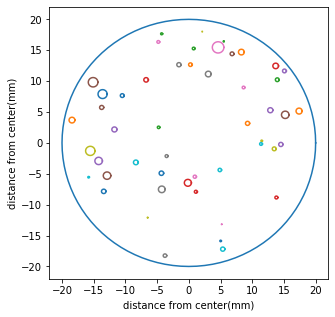

In [19]:
# Make a dataframe of follicle positions and sizes
df = make_random_follicle_df(n, ovary_r, shape_cont,scale_cont)
df = clean_up_selection(df, n_final)

# Sketch the ovary and follicles
plt.figure(figsize=(5,5))
sketch_follicles(df)
sketch_ovary(ovary_r)
plt.ylabel('distance from center(mm)')
plt.xlabel('distance from center(mm)')
len(df)

## Generate random samples of follicles

Generate two random distribution of follicluar sizes. Each distribution is composed on **n_ovaries** ovaries selected from gamma distribution. The distribution for experimental selection is shifted to the right. The shape of gamma distribion is controlled by two parameters (shape and scale). The specific values of this parameters is selected to simulate data on rats with control and HFHS diet.

In [30]:
# Create data frames to record follicle distribution in control and HFHS diet

var_list = ['gamma', 'crossed_10','crossed_50']
cont = follicle_distr(shape_cont, scale_cont)
save_follicles(cont, 'cont', var_list)

diet = follicle_distr(shape_diet, scale_diet)
save_follicles(diet, 'diet', var_list)


##  Plot control and experimental distribution of follicles

cont_gamma.csv
diet_gamma.csv
MannwhitneyuResult(statistic=9946014.0, pvalue=2.3468878078175827e-70)
cont_crossed_10.csv
diet_crossed_10.csv
MannwhitneyuResult(statistic=79186743284.0, pvalue=0.0)
cont_crossed_50.csv
diet_crossed_50.csv
MannwhitneyuResult(statistic=3168651268.0, pvalue=0.0)


C:\Users\toporikovan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


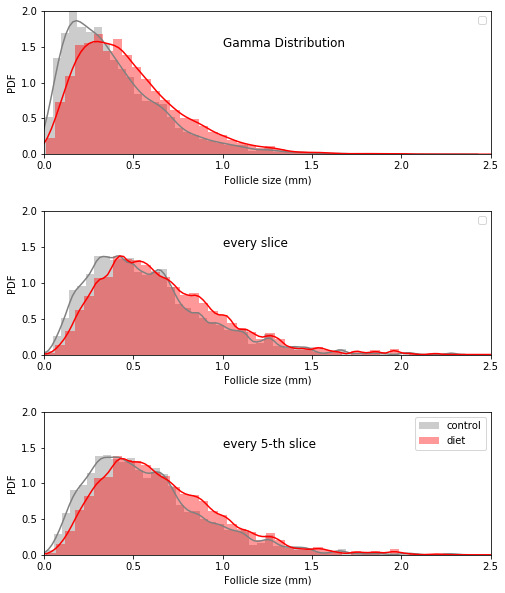

In [32]:
name_list = ['gamma', 'crossed_10','crossed_50']
colors    = ['grey',   'blue',     'red'       ]
title_list = ['Gamma Distribution', 'every slice', 'every 5-th slice']
plt.figure(figsize =( 8,10))
plt.subplots_adjust(hspace = 0.4)
for i in range(0, 3):
    filename_cont = 'cont_'+ name_list[i]+'.csv'
    print(filename_cont)
    filename_diet = 'diet_'+ name_list[i]+'.csv'
    print(filename_diet)
    df_cont = pd.read_csv(filename_cont)
    df_diet = pd.read_csv(filename_diet)
    plt.subplot(3,1,i+1)
    plt.legend(labels=['control', 'diet'])
    sns.distplot( df_cont['size'], color='grey', bins = 50, norm_hist=True)
    sns.distplot( df_diet['size'], color='red',  bins = 50, norm_hist=True)
    plt.text(1,1.5,title_list[i], fontsize = 12)
    
    plt.xlim(0,2.5)
    plt.ylim(0,2)
    plt.ylabel('PDF')
    plt.xlabel ('Follicle size (mm)')
    print (sp.stats.mannwhitneyu(df_cont['size'], df_diet['size']))
    #plt.savefig(name_list[i]) +'.png')

plt.legend(1,labels=['control', 'diet'])
plt.savefig('follicle_distribution_control_diet.png')

## Divide follicules into classes according to their size and plot number of follicles in each class for control and experimental group

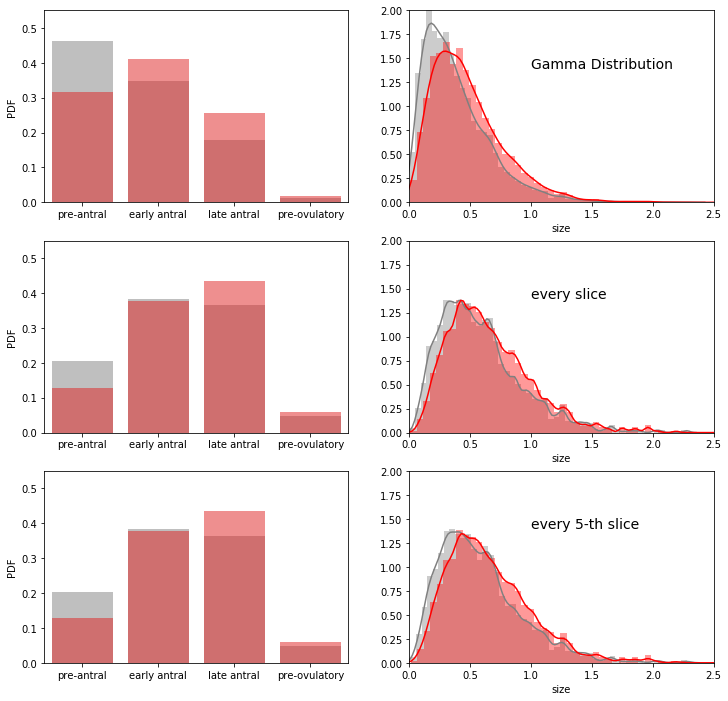

In [33]:
# Classify follicles according to their sizes
def follicle_classification(df):
    n_follicles = np.zeros(4)
    for i in range(0,4):
        df_left   = df     [ df     ['size'] < classes_size_right[i] ]
        df_within = df_left[ df_left['size'] > classes_size_left [i] ]
        n_follicles [i]= len(df_within)
    return (n_follicles)

# Introduce lists with file names, color schemes and titles for follicles
name_list  = ['gamma'             , 'crossed_10' ,'crossed_50'       ]
colors     = ['grey'              , 'blue'       , 'red'             ]
title_list = ['Gamma Distribution', 'every slice', 'every 5-th slice']

# Introduce names and size thresholod for follicular classification
classes_names      = [ 'pre-antral', 'early antral', 'late antral', 'pre-ovulatory']
classes_size_left  = [ 0           , 0.3           ,  0.6         , 1.25           ]
classes_size_right = [ 0.3         , 0.6           , 1.25         , 2.5            ]

# Prepare figure
plt.figure(figsize = (12,12))

for i in range(0, 3):
    # Download control and diet files and save them in appropriate dataframe
    filename_cont = 'cont_'+ name_list[i]+'.csv'
    filename_diet = 'diet_'+ name_list[i]+'.csv'
    
    # Separate follicles into classes
    df_cont = pd.read_csv(filename_cont)
    df_diet = pd.read_csv(filename_diet)
    #classification = pd.DataFrame(follicle_classification(df_cont), index =classes_names, columns =['control'])
    #classification['diet'] = follicle_classification(df_diet)
    
    a = follicle_classification(df_cont)
    b = follicle_classification(df_diet)
    
    #Plot barplots of normalize number of follicles in each class
    plt.subplot(3, 2,i*2+1)
    sns.barplot(x = classes_names, y =  a/np.sum(a), color = 'grey', alpha = 0.5)
    sns.barplot(x = classes_names, y =  b/np.sum(b), color = 'red', alpha = 0.5)
    plt.ylabel('PDF')
    plt.xlim(-0.5,3.5)
    plt.ylim(0, 0.55)
    
    #Plot distribution of folliclular sizes
    plt.subplot(3,2,i*2+2)
    sns.distplot( df_cont['size'], color='grey', bins = 50, norm_hist=True)
    sns.distplot( df_diet['size'], color='red',  bins = 50, norm_hist=True)
    plt.xlim(0,2.5)
    plt.ylim(0,2)
    plt.text(1, 1.4, title_list[i], fontsize = 14)

# Save figure
#plt.savefig('follicle_classes_bargraph_Diet.png')